# The script I use to start the machine learning process. It is by no means pretty. Pieces come from different tutorials so it is not uniform

In [ ]:
import os
import pandas as pd
import numpy as np
from numpy import array
from numpy import argmax

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import pickle

import seqvec
from allennlp.commands.elmo import ElmoEmbedder
from pathlib import Path
import torch


# The following is for one-hot encoding the positions in the sugars

In [ ]:
configs = ['carboxylic', 'terminal alcohol', 'aldehyde', 'terminal phosphate', 'none', 'R alcohol', 'R phosphate', 'S alcohol', 'S phosphate', 'deoxy', 'ketone']
values = array(configs)
print(values)
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
print(integer_encoded)
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print(onehot_encoded)
inverted = label_encoder.inverse_transform([argmax(onehot_encoded[0,:])])
print(inverted)

fulltable = pd.read_csv("LigandRDFeatures.csv")
positions = ['Pos1', 'Pos2', 'Pos3', 'Pos4', 'Pos5', 'Pos6']
for pos in positions:
    tmp = list(fulltable[pos])
    tmplist = []
    for item in tmp:
        i = list(values).index(item)
        j = onehot_encoded[i]
        tmplist.append(j)
    fulltable['%s_array' % (pos)] = tmplist

# The following is the one-hot encoding for the number of carbons in the sugar. It is nearly identical in form to the one-hot encoding above

In [ ]:
configs = ['C2', 'C3', 'C4', 'C5', 'C6']
values = array(configs)
print(values)
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
print(integer_encoded)
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print(onehot_encoded)
inverted = label_encoder.inverse_transform([argmax(onehot_encoded[0,:])])
print(inverted)


tmp = list(fulltable['Carbons'])
tmplist = []
for item in tmp:
    i = list(values).index(item)
    j = onehot_encoded[i]
    tmplist.append(j)
fulltable['Carbons_array'] = tmplist

# This is to join the ligand features for each ligand and to save them in a pickle file for ease of use later

In [5]:
fullligand_list = []
for index, row in fulltable.iterrows():
    t = np.concatenate((row['Carbons_array'],row['TPSA'],row['ASA'],row['HBA'],row['HBD'],row['RotBond'],row['LogP'],row['Pos1_array'],row['Pos2_array'],row['Pos3_array'],row['Pos4_array'],row['Pos5_array'],row['Pos6_array']),axis = None)
    fullligand_list.append(t)
fulltable['FullLigand'] = fullligand_list

ligembed = fulltable['FullLigand'].tolist()
pickle_out = open("Ligand_embeddings_040621.pickle", "wb")
pickle.dump(ligembed, pickle_out)
pickle_out.close()

['carboxylic' 'terminal alcohol' 'aldehyde' 'terminal phosphate' 'none'
 'R alcohol' 'R phosphate' 'S alcohol' 'S phosphate' 'deoxy' 'ketone']
[ 5  9  4 10  8  0  1  2  3  6  7]
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]
['carboxylic']
['C2' 'C3' 'C4' 'C5' 'C6']
[0 1 2 3 4]
[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]
['C2']


# The following cell is to create the seqvec embeddings for each sequence. I was able to download the model from the seqvec github. The two files needed are weights.hdf5 and options.json.

In [8]:
##Creating dictionary of uniprot codes with fasta seqs
import os
import pandas as pd
import seqvec
import numpy as np
from allennlp.commands.elmo import ElmoEmbedder
from pathlib import Path
import torch

FastaDict = {}
for fastafile in os.listdir('../../Fastas/'):
    tmp = []
    for line in open('../../Fastas/'+fastafile):
        if line[0] == '>':
            pass
        else:
            line = line.rstrip('\n')
            tmp.append(line)
    tmp = ''.join(tmp)
    FastaDict['%s' % (fastafile[:-6])] = tmp


model_dir = Path('../../../../ML_Learning/model')
weights = model_dir / 'weights.hdf5'
options = model_dir / 'options.json'
embedder = ElmoEmbedder(options, weights, cuda_device=-1)
UniList = []
EmbedList = []

for uniprot in FastaDict:
    UniList.append(uniprot)
    seq = FastaDict[uniprot]
    embedding = embedder.embed_sentence(list(seq))
    protein_embd = torch.tensor(embedding).sum(dim=0).mean(dim=0)
    Full_embed = protein_embd.numpy()

    EmbedList.append(Full_embed)
        
FullProtEmbed = pd.DataFrame()
FullProtEmbed['Uniprot'] = UniList
FullProtEmbed['Embedding'] = EmbedList

import pickle
pickle_out = open("Protein_embeddings_040621.pickle", "wb")
pickle.dump(EmbedList, pickle_out)
pickle_out.close()
FullProtEmbed['Uniprot'].to_csv('UniprotListing.csv')

# This combines each protein-ligand pair with the appropriate embeddings and saves the full features to a pickle file.

In [23]:
ProteinList = UniList
LigandList = list(fulltable['#'])
ProtEmbeddings = EmbedList
LigandEmbeddings = fullligand_list
ActivityTable = pd.read_csv('../../Activity_Table_02Hit.csv')

EmbeddingList = []
ActivityList = []
IdentityList = []

protcount = 0

LigandList.remove(147)
for uniprot in ProteinList:
    protembed = ProtEmbeddings[protcount]
    ligcount = 0
    for ligand in LigandList:
        lignum = LigandList[ligcount]

        ligembed = LigandEmbeddings[ligcount]
        entryembed = np.concatenate((protembed,ligembed),axis=None)
        ligcount += 1
        IdentityList.append('%s_%s' % (uniprot,ligand))
        EmbeddingList.append(entryembed)
        Activity = ActivityTable.loc[ActivityTable.UniprotID == uniprot, str(lignum)].values[0]
        ActivityList.append(Activity)
    protcount += 1

pickle_out = open("PairEmbeddings_040621.pickle", "wb")
pickle.dump(EmbeddingList, pickle_out)
pickle_out.close()

d = {'Pair_Identity': IdentityList, 'Activity_by_mean': ActivityList}
df = pd.DataFrame(d)
df.to_csv('Identity_Activity_040621.csv')    

# The following is to load in the pickle file and the activity csv file to use for machine learning. This is for when you have created the embeddings previously.

In [2]:
pickle_in = open("PairEmbeddings_040621.pickle" , "rb")
EmbeddingList = pickle.load(pickle_in)

df = pd.read_csv('Identity_Activity_040621.csv')
ActivityList = df['Activity_by_mean'].tolist()

# These are the imports and the splitting of the data into training and validation. I am sorry for import inconsistencies. 

In [ ]:
import sys
import scipy
import numpy
import matplotlib
import pandas
import sklearn
from pandas import read_csv
from pandas.plotting import scatter_matrix
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import sklearn.metrics
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn import neural_network
from scipy.stats import randint as sp_randint
from scipy.stats import uniform 
from numpy import arange
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

X_train, X_validation, Y_train, Y_validation = train_test_split(EmbeddingList, ActivityList, test_size=0.1)

# This is to test a variety of default methods and compare the results

LR: 0.481128 (0.018150)
LDA: 0.532281 (0.011386)
KNN: 0.424668 (0.024565)
CART: 0.533984 (0.014988)
NB: 0.394714 (0.018511)


C:\Users\Tim\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Tim\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Tim\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Tim\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Tim\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Tim\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Tim\anaconda3\lib\site-packages\sklea

QDA: 0.376002 (0.011634)
RDG: 0.465706 (0.019636)


C:\Users\Tim\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Tim\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Tim\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Tim\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceW

MLPNN: 0.642368 (0.028261)


C:\Users\Tim\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


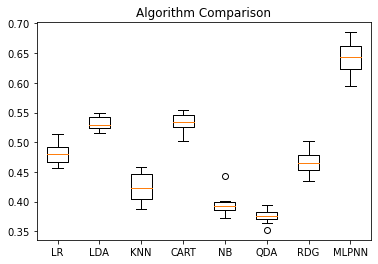

In [30]:
#Spot Check Algorithms
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
#models.append(('SVM', SVC(gamma='auto')))
models.append(('QDA', sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis()))
models.append(('RDG', sklearn.linear_model.RidgeClassifier()))
models.append(('MLPNN', sklearn.neural_network.MLPClassifier()))

              
#evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold=StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='f1')
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
    
pyplot.boxplot(results, labels=names)
pyplot.title('Algorithm Comparison')
pyplot.show()

# Train a model on the full training set and test on the validation set. Variety of metrics printed.

In [5]:
#Make predictions on validation dataset
model = sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(100,100))
model.fit(X_train, Y_train)


#Evaluate predictions
print(sklearn.metrics.accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.8653100775193798
[[1565  154]
 [ 124  221]]
              precision    recall  f1-score   support

           0       0.93      0.91      0.92      1719
           1       0.59      0.64      0.61       345

    accuracy                           0.87      2064
   macro avg       0.76      0.78      0.77      2064
weighted avg       0.87      0.87      0.87      2064



C:\Users\Tim\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


# Hyperparameter tuning of the MLP Classifier. The n_iter indicates how many parameters are sampled, so that would need to be much higher to be useful. GridSearchCV is an alternative to RandomizedSearchCV where it will go through parameter options exhaustively. 

In [45]:
model = sklearn.neural_network.MLPClassifier()

parameter_space = {
    'hidden_layer_sizes': [(sp_randint.rvs(100,600,1),sp_randint.rvs(100,600,1),), 
                                          (sp_randint.rvs(100,600,1),)],
    'activation': ['tanh', 'identity', 'relu', 'logistic'],
    'solver': ['sgd', 'adam', 'lbfgs'],
    'alpha': uniform(0.0001, 0.9),
    'learning_rate': ['constant','adaptive']}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=42)

search = sklearn.model_selection.RandomizedSearchCV(model,parameter_space, scoring='f1',cv=cv, n_iter=1)
results = search.fit(X_train, Y_train)
print('top f1: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

C:\Users\Tim\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Tim\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Tim\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATION

top f1: 0.526
Config: {'activation': 'identity', 'alpha': 0.3464965142407303, 'hidden_layer_sizes': (386, 256), 'learning_rate': 'adaptive', 'solver': 'lbfgs'}


C:\Users\Tim\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
